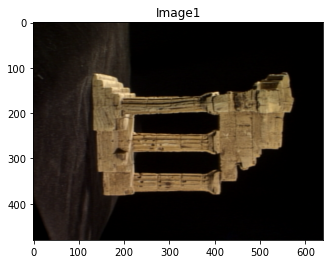

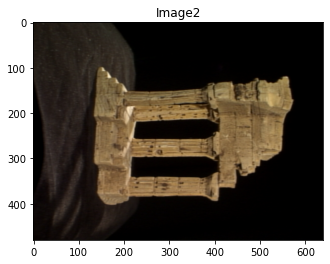

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

f = open('templeSR_par.txt')
assert f is not None
n = int(f.readline())
#Read the information of the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
#Read the information of the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
#Read the 2 image and show
im1 = cv.imread(r'./templeSparseRing/' + im1_fn ,cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn ,cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None
im1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
plt.imshow(im1)
plt.title('Image1')
plt.show()
plt.imshow(im2)
plt.title('Image2')
plt.show()

In [8]:
sift = cv.SIFT_create()
kp1,des1 = sift.detectAndCompute(im1,None)
kp2,des2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
 if m.distance < 0.7*n.distance:
     good.append(m)
     pts2.append(kp2[m.trainIdx].pt)
     pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.array(pts1)
pts2 = np.array(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)#fundamental matrix

E = K2.T @ F @ K1#essential matrix
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)

R_t_1 = np.concatenate((R1,t1),axis=1)#
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_,t2_),axis=1)

P1 = K1 @ np.hstack((R1,t1)) #first cameras matrix from data read from file
P2_ = K2 @ R_t_2 #second camera matrix estimated from the fundamental matrix computed via point matches


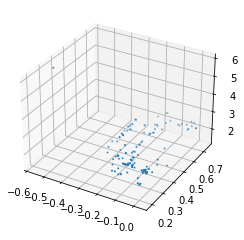

In [11]:
points4d = cv.triangulatePoints(P1,P2_,pts1.T,pts2.T)
points4d /= points4d[3,:]
X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(1)
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X,Y,Z,s=1,cmap='gray')
plt.show()
